In [1]:
import os
import cv2
import time
import json
import pickle
import numpy as np
import torch
from torch.autograd import Variable
from matplotlib import pyplot as plt
from cnn import SegmentationModel as net

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print('Torch:' + torch.__version__)
print('Opencv:' + cv2.__version__)

cuda
Torch:1.1.0
Opencv:4.1.1


In [3]:
def bb_iou(boxes1, boxes2):
    x11, y11, x12, y12 = np.split(boxes1, 4, axis=1)
    x21, y21, x22, y22 = np.split(boxes2, 4, axis=1)
    xA = np.maximum(x11, np.transpose(x21))
    yA = np.maximum(y11, np.transpose(y21))
    xB = np.minimum(x12, np.transpose(x22))
    yB = np.minimum(y12, np.transpose(y22))
    interArea = np.maximum((xB - xA + 1), 0) * np.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / (boxAArea + np.transpose(boxBArea) - interArea)
    return iou

In [4]:
def colorir(cat):
    h, w = cat.shape[:2]
    msk = np.zeros((h,w,3), dtype = 'uint8')
    msk[cat == 1] = [0,255,0]
    msk[cat == 2] = [0,0,255]
    return(msk)

In [5]:
def get_bboxes(contours, minArea, maxArea, minDst, maxDst):
    bboxes = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        bbox = cv2.boundingRect(cnt)
        x,y,w,h = np.array(bbox)
        if area >  minArea and area < maxArea:
            if (x > minDst) and ((x+w) < maxDst):
                bboxes.append([x,y,x+w,y+h])
    return(np.array(bboxes))

In [6]:
def transform(x):
    x = x.copy()
    x = x.astype('float')
    x -= 128
    x /= 35
    x = np.moveaxis(x, 2, 0)
    x = x[np.newaxis]
    x = torch.from_numpy(x)
    x = Variable(x).to(device, dtype=torch.float)
    return(x)

In [7]:
def get_cat(frame):
    img = transform(frame)
    pred, feat = model(img)
    pred = pred.cpu().data.numpy()
    pred = np.moveaxis(pred, 1, 3)
    pred = np.squeeze(pred)
    cat = np.argmax(pred, 2).astype('uint8')
    return(cat)

In [8]:
n_classes = 3

# Atribui o modelo
model = net.EESPNet_Seg(n_classes, s=0.5, pretrained='', gpus=1)
model = model.to(device)
model.load_state_dict(torch.load('../data/Tracking.pth',map_location=device))


# set to evaluation mode
model.eval()

print('Modelo Ok')

Modelo Ok


In [9]:
frames_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Plantas/'
msks_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Pred/'
video_dir = '/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/'


In [10]:
input_height = 1080
input_width = 1920

output_height = 384
output_width = 512

ioh, iow = input_height/output_height, input_width/output_width
iocv = np.array([iow, ioh, iow, ioh])

video_files = sorted(os.listdir(video_dir))
video_files = [os.path.join(video_dir, v) for v in video_files if not v.endswith(('.json', '_bb.avi'))]

font = cv2.FONT_HERSHEY_SIMPLEX  
ini_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 5))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
  

In [11]:
print(video_files)
iocv

['/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/20190726.avi']


array([3.75  , 2.8125, 3.75  , 2.8125])

In [12]:
for vid in range(len(video_files)):
    video_file = video_files[vid]
    save_file = video_file.replace('.avi', '_bb.avi')
    json_file = save_file.replace('.avi', '.json')

    out = cv2.VideoWriter(save_file, fourcc, 30.0, (output_width, output_height))
    print(save_file)

    old_plant_boxes = new_plant_boxes = tmp_plant_boxes = np.array([]) # inicialize the boxes vector
    old_stem_boxes = new_stem_boxes = tmp_stem_boxes = np.array([])
    video_history = {}

    n_plantas = 1 # counter
    n_frames = 1
    speed = 25 
    last_speed = speed
    speed_avg = speed * np.ones(10)
    
    
    cap = cv2.VideoCapture(video_file)
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#   n_frames = 75
    t_start = time.time()                 
    for i in range(n_frames):
        print(i)
        start_time = time.time()
        res, frameo = cap.read()
        frame = cv2.resize(frameo, (output_width, output_height))
        cat = get_cat(frame)
       
        # apply the overlay
        alpha = 0.5
        pred = colorir(cat)
        mskf = np.zeros_like(cat)
        framec = cv2.resize(pred, (output_width, output_height))
        cv2.addWeighted(framec, alpha, frame, 1 - alpha, 0, frame)
    
        
        # Cria duas mascaras, a primeira para planta + tubete e a segunda apenas do tubete:
        plant_msk = (cat > 0).astype('uint8')
        stem_msk = (cat == 2).astype('uint8')
        
        # Aplica um kernel vertical, para evitar que existam interrupcoes no contorno das plantas,
        # o que causaria a existencia de dois bbox:
        plant_msk = cv2.dilate(plant_msk, ini_kernel, iterations = 15)
        stem_msk = cv2.dilate(stem_msk, ini_kernel, iterations = 5)
        
        # Encontra os bbox das plantas com tubetes, que depois eh enconlhido para ficar soh a planta:
        contours, hierarchy = cv2.findContours(plant_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        new_plant_boxes = get_bboxes(contours, 5000, 500000, 10, 500)
        
        # Encontra os bbox dos tubetes, que depois sao movidos para a posicao do caule:
        contours, hierarchy = cv2.findContours(stem_msk, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        new_stem_boxes = get_bboxes(contours, 100, 10000, 10, 500) 
        
        if new_plant_boxes.size > 0:
            # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
            new_plant_boxes = new_plant_boxes[new_plant_boxes[:,0].argsort()[::-1]]
            
            # Define um criterio para os bbox que estao apenas na primeira metade do video:
            mcrit = np.ones(len(new_plant_boxes), dtype=bool)
            mcrit[new_plant_boxes[:,0] < 10] = False
            mcrit[new_plant_boxes[:,2] > frame.shape[1]/2] = False

            # Se ja existem bbox anteriores, atualiza com os correspondentes:
            if old_plant_boxes.size > 0 :
                areas = bb_iou(new_plant_boxes, old_plant_boxes)
                ncrit = np.where(areas.max(0) > 0)
                acrit = areas.argmax(0)[ncrit]
                old_plant_boxes[ncrit] = new_plant_boxes[acrit]
                mcrit[acrit] = False
            
            # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
            tmp_plant_boxes = new_plant_boxes[mcrit]
                
        
        if new_stem_boxes.size > 0:
            # Ordena os bbox pelo eixo x, para que o primeiro fique a direita e o ultimo a esquerda:
            new_stem_boxes = new_stem_boxes[new_stem_boxes[:,0].argsort()[::-1]]       
            
            # Define um criterio para os bbox que estao apenas na primeira metade do video:
            mcrit = np.ones(len(new_stem_boxes), dtype=bool)
            mcrit[new_stem_boxes[:,0] < 10] = False
            mcrit[new_stem_boxes[:,2] > frame.shape[1]/2] = False
            
            # Se ja existem bbox anteriores, atualiza com os correspondentes:
            if old_stem_boxes.size > 0 :
                areas = bb_iou(new_stem_boxes, old_stem_boxes)
                ncrit = np.where(areas.max(0) > 0)
                acrit = areas.argmax(0)[ncrit]        
                
                # Utiliza os bbox correspondentes para calcular a velocidade (px/frame):
                # Obs: O calculo ocorre aqui porque eh mais estavel calcular com base nos tubetes
                last_speed += np.mean(new_stem_boxes[acrit,0] - old_stem_boxes[ncrit,0])
                if last_speed > 0:
                    speed_avg = np.insert(speed_avg, 0, last_speed)[:10]
                    print("Speed:" + str(speed))
                else:
                    last_speed = speed
                speed = int(np.mean(speed_avg))
                old_stem_boxes[ncrit] = new_stem_boxes[acrit]
                mcrit[acrit] = False
            # Armazena os bbox nao correspondentes, eles seram avaliados ao final e incluidos se forem validos:
            tmp_stem_boxes = new_stem_boxes[mcrit]
                
        
        # Se for a primeira planta a ser identificada, atribui o bbox para plotar:
        if old_plant_boxes.size == 0 and old_stem_boxes.size == 0 :
            if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 :
                old_stem_boxes = tmp_stem_boxes
                old_plant_boxes = tmp_plant_boxes
                tmp_stem_boxes = tmp_plant_boxes = np.array([])

            
        # Inicia o dicionario que vai salvar as coordendas dos dois bbox para cada planta:
        frame_str = {}
        if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
            # Garante que os bbox da planta e do caule sao da mesma planta (intersectam):
            areas = bb_iou(old_plant_boxes, old_stem_boxes)
            nidx = areas.argmax(1)
                        
            for idx, ix in enumerate(nidx):
                sbb = old_stem_boxes[ix].copy()
                if areas.max(1)[idx] > 0 and (sbb[0] > 10) and (frame.shape[1] - sbb[2]) > 10:
                    
                    # Para cada bbox da planta realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                    bb = old_plant_boxes[idx].copy()
                    bb[3] = sbb[1] + 10
                    
                    mskf = cv2.rectangle(mskf,(bb[0], bb[1]), (bb[2], bb[3]),(1), -1)
                    mskf = cv2.rectangle(mskf,(sbb[0], sbb[1]),(sbb[2], sbb[3]),(2), -1)
                    cv2.imwrite(msks_dir + 'F{:04d}.png'.format(i), mskf)
        
                    plant_bb = np.int0(bb*iocv).tolist()
                    frame = cv2.rectangle(frame,(bb[0], bb[1]), (bb[2], bb[3]),(0,0,255), 2)
                    cv2.putText(frame, 'P{}'.format(idx + n_plantas),(int(np.mean(bb[[0,2]])), bb[1]), font, 1,(255,255,255),2,cv2.LINE_AA)

                    # Para cada bbox do caule realiza os ajustes na posicao, plota no frame e adiciona no dicionario:
                    xm = int(np.mean(sbb[[0,2]]))
                    sbb[[0,2]] = xm + np.array([-20,20])
                    sbb[[1,3]] = [sbb[1] - 10, sbb[1] + 10]                    
                    stem_bb = np.int0(sbb*iocv).tolist()
                    frame = cv2.rectangle(frame,(sbb[0], sbb[1]),(sbb[2], sbb[3]),(255,0,0), 2)
                    cv2.putText(frame, 'P{}'.format(idx + n_plantas),(xm, sbb[3]), font, 1,(255,255,255),2,cv2.LINE_AA)
                   
                    frame_str['P{}'.format(idx + n_plantas)] = {'Plant':plant_bb, 'Stem':stem_bb}


        # Adiciona ao dicionario do video as informacoes desse frame:
        video_history['Frame{:04d}'.format(i)] = frame_str
        frame_bbox = frame_str
        for p in frame_bbox.keys():
            f_bbox = frame_bbox.get(p)
            pbox = np.array(f_bbox.get('Plant'))
            pbox = np.int0(pbox)#*iocv)
            pbox[1] += 80               
            pbox[3] += 40               
            plantf_name = '_{}_F{:04d}.jpg'.format(p, i)
            plant_file = frames_dir + plantf_name
            cv2.imwrite(plant_file,frameo[pbox[1]:pbox[3], pbox[0]:pbox[2]])
        print(frame_str)
        
        # Nessa parte vou adicionar o outro modelo, que vai fazer a classificacao:
        # classificar(frame, planta)
        
        # Se existem novos bbox, adiciona ao conjunto que sera avaliado no proximo frame:
        if tmp_plant_boxes.size > 0 and tmp_stem_boxes.size > 0 and tmp_plant_boxes.size == tmp_stem_boxes.size:
            old_stem_boxes = np.concatenate([tmp_stem_boxes, old_stem_boxes])
            old_plant_boxes = np.concatenate([tmp_plant_boxes, old_plant_boxes])

        # Realiza a predicao da posicao de cada bbox no proximo frame, com base na velocidade instantanea:
        if old_plant_boxes.size > 0 and old_stem_boxes.size > 0 :
            old_stem_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
            old_stem_boxes = old_stem_boxes[old_stem_boxes[:,0].argsort()[::-1]]
            
            old_plant_boxes += np.int0(last_speed * np.array([[1,0,1,0]]))
            old_plant_boxes = old_plant_boxes[old_plant_boxes[:,0].argsort()[::-1]]
            
            # Remove os bbox que estarao fora da imagem, e conta como uma nova planta:
            # Obs: Esse sera o momento de enviar o controle com a classificacao da planta
            fcrit = old_stem_boxes[:,3] < frame.shape[1]
            if not fcrit.all():
                old_plant_boxes = old_plant_boxes[fcrit]
                old_stem_boxes = old_stem_boxes[fcrit]
                n_plantas += 1         
        
        
        # Estou salvando apenas os frames com planta e movimento detectados:
        if last_speed > 10 and len(frame_str) > 0:
            out.write(frame)
        
        t_now = time.time()
        
        
        fps = i /(t_now - t_start)
        if i % 10 == 0:
            print('Running at {} FPS'.format(fps))
    
    cap.release()
    out.release()
    
    # Salva o dicionario em json com as informacoes desse video:
    with open(json_file, 'w') as outfile:
        json.dump(video_history, outfile)
        
    time_taken = time.time() - start_time
    print('PreProc time: %.2f' % time_taken)  



/home/rodrigo7/Notebook/Datasets/Eucalyptus2/Videos/20190726_bb.avi
0
{}
Running at 0.0 FPS
1
{}
2
{}
3
{}
4
{}
5
{}
6
{}
7
{}
8
{}
9
{}
10
{}
Running at 9.393085810391664 FPS
11
{}
12
{}
13
{}
14
{}
15
{}
16
{}
17
{}
18
{}
19
{}
20
{}
Running at 14.296070126787475 FPS
21
{}
22
{}
23
{}
24
{}
25
{}
26
{}
27
{}
28
{}
29
{}
30
{}
Running at 17.286625185619922 FPS
31
{}
32
{}
33
{}
34
{}
35
{}
36
{}
37
{}
38
{}
39
{}
40
{}
Running at 18.825926772497603 FPS
41
{}
42
{}
43
{}
44
{}
45
{}
46
{}
47
{}
48
{}
49
{}
50
{}
Running at 19.845520867893296 FPS
51
{}
52
{}
53
{}
54
{}
55
{}
56
{}
57
{}
58
{}
59
{}
60
{}
Running at 20.695100713544367 FPS
61
{}
62
{}
63
{}
64
{}
65
{}
66
{}
67
{}
68
{}
69
{}
70
{}
Running at 21.405574596826376 FPS
71
{}
72
{}
73
{}
74
{}
75
{'P1': {'Plant': [56, 565, 397, 900], 'Stem': [26, 843, 176, 900]}}
76
Speed:25
{'P1': {'Plant': [112, 556, 446, 902], 'Stem': [78, 846, 228, 902]}}
77
Speed:23
{'P1': {'Plant': [176, 545, 483, 897], 'Stem': [142, 840, 292, 897]}}
78

Speed:12
{'P3': {'Plant': [795, 540, 1061, 880], 'Stem': [915, 824, 1065, 880]}}
154
Speed:12
{'P3': {'Plant': [851, 545, 1132, 880], 'Stem': [971, 824, 1121, 880]}}
155
Speed:13
{'P3': {'Plant': [900, 548, 1200, 880], 'Stem': [1020, 824, 1170, 880]}}
156
Speed:13
{'P3': {'Plant': [952, 548, 1278, 880], 'Stem': [1076, 824, 1226, 880]}}
157
Speed:13
{'P3': {'Plant': [990, 548, 1316, 880], 'Stem': [1102, 824, 1252, 880]}}
158
Speed:12
{'P3': {'Plant': [1061, 551, 1368, 877], 'Stem': [1143, 821, 1293, 877]}}
159
Speed:13
{'P3': {'Plant': [1173, 556, 1417, 880], 'Stem': [1192, 824, 1342, 880]}}
160
Speed:12
{'P3': {'Plant': [1226, 551, 1458, 883], 'Stem': [1252, 826, 1402, 883]}, 'P4': {'Plant': [146, 585, 525, 902], 'Stem': [108, 846, 258, 902]}}
Running at 23.242396566813756 FPS
161
Speed:13
{'P3': {'Plant': [1263, 548, 1533, 883], 'Stem': [1293, 826, 1443, 883]}, 'P4': {'Plant': [187, 568, 596, 897], 'Stem': [150, 840, 300, 897]}}
162
Speed:12
{'P3': {'Plant': [1338, 545, 1612, 885], 'S

Speed:12
{'P5': {'Plant': [1728, 506, 2006, 888], 'Stem': [1766, 832, 1916, 888]}, 'P6': {'Plant': [393, 570, 768, 883], 'Stem': [622, 826, 772, 883]}}
222
Speed:13
{'P6': {'Plant': [468, 568, 810, 880], 'Stem': [667, 824, 817, 880]}}
223
Speed:12
{'P6': {'Plant': [626, 568, 866, 883], 'Stem': [723, 826, 873, 883]}}
224
Speed:13
{'P6': {'Plant': [757, 568, 948, 883], 'Stem': [765, 826, 915, 883]}}
225
Speed:12
{'P6': {'Plant': [817, 562, 1072, 885], 'Stem': [810, 829, 960, 885]}}
226
Speed:12
{'P6': {'Plant': [873, 565, 1196, 885], 'Stem': [858, 829, 1008, 885]}}
227
Speed:12
{'P6': {'Plant': [918, 556, 1260, 880], 'Stem': [903, 824, 1053, 880]}}
228
Speed:13
{'P6': {'Plant': [967, 551, 1308, 880], 'Stem': [960, 824, 1110, 880]}}
229
Speed:13
{'P6': {'Plant': [990, 545, 1327, 880], 'Stem': [990, 824, 1140, 880]}}
230
Speed:12
{'P6': {'Plant': [1042, 540, 1361, 883], 'Stem': [1042, 826, 1192, 883]}}
Running at 23.375799206498787 FPS
231
Speed:12
{'P6': {'Plant': [1095, 537, 1365, 877], 

Speed:12
{'P9': {'Plant': [682, 514, 960, 883], 'Stem': [663, 826, 813, 883]}}
313
Speed:12
{'P9': {'Plant': [716, 511, 967, 883], 'Stem': [708, 826, 858, 883]}}
314
Speed:11
{'P9': {'Plant': [731, 514, 952, 880], 'Stem': [753, 824, 903, 880]}}
315
Speed:12
{'P9': {'Plant': [753, 517, 952, 883], 'Stem': [787, 826, 937, 883]}}
316
Speed:12
{'P9': {'Plant': [791, 514, 986, 880], 'Stem': [847, 824, 997, 880]}}
317
Speed:11
{'P9': {'Plant': [783, 517, 1020, 880], 'Stem': [885, 824, 1035, 880]}}
318
Speed:12
{'P9': {'Plant': [798, 523, 1068, 877], 'Stem': [926, 821, 1076, 877]}}
319
Speed:12
{'P9': {'Plant': [813, 523, 1102, 880], 'Stem': [967, 824, 1117, 880]}}
320
Speed:11
{'P9': {'Plant': [855, 520, 1170, 877], 'Stem': [1023, 821, 1173, 877]}}
Running at 23.865846847377085 FPS
321
Speed:12
{'P9': {'Plant': [881, 514, 1200, 877], 'Stem': [1065, 821, 1215, 877]}}
322
Speed:11
{'P9': {'Plant': [975, 517, 1252, 877], 'Stem': [1117, 821, 1267, 877]}}
323
Speed:12
{'P9': {'Plant': [1065, 517, 

Speed:13
{'P11': {'Plant': [1638, 559, 1961, 888], 'Stem': [1702, 832, 1852, 888]}, 'P12': {'Plant': [506, 523, 765, 883], 'Stem': [543, 826, 693, 883]}}
385
Speed:14
{'P11': {'Plant': [1695, 559, 2017, 891], 'Stem': [1728, 835, 1878, 891]}, 'P12': {'Plant': [506, 520, 757, 883], 'Stem': [573, 826, 723, 883]}}
386
Speed:13
{'P11': {'Plant': [1721, 559, 2043, 891], 'Stem': [1766, 835, 1916, 891]}, 'P12': {'Plant': [521, 523, 757, 883], 'Stem': [615, 826, 765, 883]}}
387
Speed:13
{'P12': {'Plant': [543, 523, 802, 883], 'Stem': [660, 826, 810, 883]}}
388
Speed:13
{'P12': {'Plant': [581, 525, 862, 883], 'Stem': [720, 826, 870, 883]}}
389
Speed:13
{'P12': {'Plant': [588, 528, 911, 880], 'Stem': [765, 824, 915, 880]}}
390
Speed:13
{'P12': {'Plant': [611, 531, 945, 883], 'Stem': [798, 826, 948, 883]}}
Running at 24.030934997055446 FPS
391
Speed:12
{'P12': {'Plant': [671, 528, 1001, 880], 'Stem': [855, 824, 1005, 880]}}
392
Speed:12
{'P12': {'Plant': [701, 531, 1035, 880], 'Stem': [896, 824, 1

Speed:13
{'P14': {'Plant': [1440, 537, 1743, 880], 'Stem': [1623, 824, 1773, 880]}, 'P15': {'Plant': [311, 517, 622, 883], 'Stem': [491, 826, 641, 883]}}
460
Speed:12
{'P14': {'Plant': [1455, 540, 1803, 891], 'Stem': [1680, 835, 1830, 891]}, 'P15': {'Plant': [360, 520, 690, 885], 'Stem': [551, 829, 701, 885]}}
Running at 24.085952519742285 FPS
461
Speed:13
{'P14': {'Plant': [1492, 542, 1833, 888], 'Stem': [1725, 832, 1875, 888]}, 'P15': {'Plant': [416, 520, 742, 883], 'Stem': [596, 826, 746, 883]}}
462
Speed:12
{'P14': {'Plant': [1533, 542, 1875, 888], 'Stem': [1773, 832, 1923, 888]}, 'P15': {'Plant': [510, 517, 813, 883], 'Stem': [660, 826, 810, 883]}}
463
Speed:12
{'P15': {'Plant': [603, 517, 843, 880], 'Stem': [697, 824, 847, 880]}}
464
Speed:12
{'P15': {'Plant': [727, 514, 933, 883], 'Stem': [753, 826, 903, 883]}}
465
Speed:12
{'P15': {'Plant': [810, 511, 1046, 883], 'Stem': [806, 826, 956, 883]}}
466
Speed:13
{'P15': {'Plant': [866, 511, 1117, 880], 'Stem': [847, 824, 997, 880]}}


Speed:13
{'P17': {'Plant': [1162, 486, 1518, 888], 'Stem': [1398, 832, 1548, 888]}, 'P18': {'Plant': [180, 559, 431, 894], 'Stem': [213, 838, 363, 894]}}
530
Speed:12
{'P17': {'Plant': [1215, 489, 1575, 885], 'Stem': [1451, 829, 1601, 885]}, 'P18': {'Plant': [247, 556, 465, 891], 'Stem': [270, 835, 420, 891]}}
Running at 24.17395854456048 FPS
531
Speed:12
{'P17': {'Plant': [1256, 495, 1612, 885], 'Stem': [1496, 829, 1646, 885]}, 'P18': {'Plant': [285, 551, 540, 894], 'Stem': [311, 838, 461, 894]}}
532
Speed:13
{'P17': {'Plant': [1320, 506, 1668, 885], 'Stem': [1552, 829, 1702, 885]}, 'P18': {'Plant': [345, 542, 622, 891], 'Stem': [371, 835, 521, 891]}}
533
Speed:12
{'P17': {'Plant': [1436, 503, 1725, 888], 'Stem': [1608, 832, 1758, 888]}, 'P18': {'Plant': [423, 540, 678, 888], 'Stem': [431, 832, 581, 888]}}
534
Speed:13
{'P17': {'Plant': [1533, 503, 1818, 888], 'Stem': [1650, 832, 1800, 888]}, 'P18': {'Plant': [446, 537, 720, 883], 'Stem': [476, 826, 626, 883]}}
535
Speed:13
{'P17': {'

Speed:12
{'P20': {'Plant': [1260, 528, 1560, 891], 'Stem': [1365, 835, 1515, 891]}, 'P21': {'Plant': [165, 531, 408, 888], 'Stem': [135, 832, 285, 888]}}
604
Speed:12
{'P20': {'Plant': [1402, 531, 1653, 888], 'Stem': [1417, 832, 1567, 888]}, 'P21': {'Plant': [221, 531, 483, 888], 'Stem': [187, 832, 337, 888]}}
605
Speed:12
{'P20': {'Plant': [1496, 531, 1728, 885], 'Stem': [1462, 829, 1612, 885]}, 'P21': {'Plant': [266, 525, 540, 888], 'Stem': [232, 832, 382, 888]}}
606
Speed:12
{'P20': {'Plant': [1552, 531, 1803, 891], 'Stem': [1518, 835, 1668, 891]}, 'P21': {'Plant': [322, 523, 603, 885], 'Stem': [288, 829, 438, 885]}}
607
Speed:13
{'P20': {'Plant': [1597, 531, 1845, 894], 'Stem': [1560, 838, 1710, 894]}, 'P21': {'Plant': [356, 523, 618, 885], 'Stem': [333, 829, 483, 885]}}
608
Speed:12
{'P20': {'Plant': [1642, 531, 1890, 888], 'Stem': [1601, 832, 1751, 888]}, 'P21': {'Plant': [375, 528, 622, 888], 'Stem': [375, 832, 525, 888]}}
609
Speed:12
{'P20': {'Plant': [1683, 531, 1931, 888], '

Speed:13
{'P23': {'Plant': [1166, 492, 1376, 880], 'Stem': [1185, 824, 1335, 880]}}
675
Speed:12
{'P23': {'Plant': [1192, 495, 1387, 883], 'Stem': [1203, 826, 1353, 883]}}
676
Speed:11
{'P23': {'Plant': [1203, 495, 1391, 883], 'Stem': [1263, 826, 1413, 883]}}
677
Speed:12
{'P23': {'Plant': [1211, 495, 1428, 885], 'Stem': [1305, 829, 1455, 885]}}
678
Speed:12
{'P23': {'Plant': [1222, 495, 1470, 888], 'Stem': [1350, 832, 1500, 888]}}
679
Speed:12
{'P23': {'Plant': [1241, 497, 1530, 888], 'Stem': [1406, 832, 1556, 888]}, 'P24': {'Plant': [78, 601, 356, 894], 'Stem': [217, 838, 367, 894]}}
680
Speed:12
{'P23': {'Plant': [1275, 503, 1567, 888], 'Stem': [1443, 832, 1593, 888]}, 'P24': {'Plant': [213, 599, 517, 897], 'Stem': [262, 840, 412, 897]}}
Running at 24.32637793596613 FPS
681
Speed:12
{'P23': {'Plant': [1312, 503, 1608, 888], 'Stem': [1488, 832, 1638, 888]}, 'P24': {'Plant': [337, 596, 663, 894], 'Stem': [303, 838, 453, 894]}}
682
Speed:12
{'P23': {'Plant': [1387, 506, 1665, 885], 'St

Speed:13
{'P26': {'Plant': [956, 531, 1132, 880], 'Stem': [948, 824, 1098, 880]}}
746
Speed:13
{'P26': {'Plant': [956, 531, 1132, 880], 'Stem': [993, 824, 1143, 880]}}
747
Speed:13
{'P26': {'Plant': [933, 534, 1170, 880], 'Stem': [1031, 824, 1181, 880]}}
748
Speed:12
{'P26': {'Plant': [922, 534, 1222, 880], 'Stem': [1080, 824, 1230, 880]}}
749
Speed:12
{'P26': {'Plant': [922, 537, 1260, 880], 'Stem': [1121, 824, 1271, 880]}}
750
Speed:12
{'P26': {'Plant': [945, 542, 1312, 880], 'Stem': [1177, 824, 1327, 880]}}
Running at 24.243123355191898 FPS
751
Speed:13
{'P26': {'Plant': [990, 545, 1357, 883], 'Stem': [1203, 826, 1353, 883]}}
752
Speed:11
{'P26': {'Plant': [1057, 551, 1395, 885], 'Stem': [1267, 829, 1417, 885]}, 'P27': {'Plant': [105, 531, 382, 908], 'Stem': [60, 852, 210, 908]}}
753
Speed:12
{'P26': {'Plant': [1128, 551, 1440, 885], 'Stem': [1312, 829, 1462, 885]}, 'P27': {'Plant': [150, 531, 412, 902], 'Stem': [116, 846, 266, 902]}}
754
Speed:12
{'P26': {'Plant': [1233, 500, 1488,

818
Speed:13
{'P29': {'Plant': [746, 548, 1001, 877], 'Stem': [787, 821, 937, 877]}}
819
Speed:13
{'P29': {'Plant': [810, 542, 1076, 880], 'Stem': [840, 824, 990, 880]}}
820
Speed:13
{'P29': {'Plant': [862, 540, 1125, 880], 'Stem': [881, 824, 1031, 880]}}
Running at 24.263597855492367 FPS
821
Speed:13
{'P29': {'Plant': [918, 537, 1170, 877], 'Stem': [933, 821, 1083, 877]}}
822
Speed:13
{'P29': {'Plant': [930, 531, 1218, 880], 'Stem': [971, 824, 1121, 880]}}
823
Speed:12
{'P29': {'Plant': [956, 528, 1252, 880], 'Stem': [1020, 824, 1170, 880]}}
824
Speed:12
{'P29': {'Plant': [982, 528, 1282, 880], 'Stem': [1080, 824, 1230, 880]}}
825
Speed:13
{'P29': {'Plant': [1008, 525, 1293, 880], 'Stem': [1121, 824, 1271, 880]}}
826
Speed:12
{'P29': {'Plant': [1050, 528, 1305, 880], 'Stem': [1158, 824, 1308, 880]}}
827
Speed:12
{'P29': {'Plant': [1121, 531, 1372, 880], 'Stem': [1211, 824, 1361, 880]}}
828
Speed:13
{'P29': {'Plant': [1151, 531, 1406, 880], 'Stem': [1237, 824, 1387, 880]}, 'P30': {'Pla

Speed:13
{'P32': {'Plant': [401, 542, 843, 880], 'Stem': [693, 824, 843, 880]}}
Running at 24.256174818835884 FPS
891
Speed:12
{'P32': {'Plant': [416, 554, 900, 880], 'Stem': [750, 824, 900, 880]}}
892
Speed:13
{'P32': {'Plant': [483, 551, 941, 880], 'Stem': [791, 824, 941, 880]}}
893
Speed:12
{'P32': {'Plant': [611, 554, 990, 880], 'Stem': [847, 824, 997, 880]}}
894
Speed:13
{'P32': {'Plant': [701, 554, 1031, 883], 'Stem': [888, 826, 1038, 883]}}
895
Speed:12
{'P32': {'Plant': [847, 554, 1151, 880], 'Stem': [941, 824, 1091, 880]}}
896
Speed:13
{'P32': {'Plant': [978, 548, 1230, 883], 'Stem': [982, 826, 1132, 883]}}
897
Speed:12
{'P32': {'Plant': [1042, 542, 1383, 883], 'Stem': [1031, 826, 1181, 883]}}
898
Speed:12
{'P32': {'Plant': [1083, 537, 1492, 880], 'Stem': [1080, 824, 1230, 880]}}
899
Speed:12
{'P32': {'Plant': [1136, 525, 1575, 880], 'Stem': [1136, 824, 1286, 880]}}
900
Speed:13
{'P32': {'Plant': [1192, 523, 1597, 880], 'Stem': [1177, 824, 1327, 880]}}
Running at 24.2663071010

Speed:12
{'P34': {'Plant': [1766, 509, 2032, 888], 'Stem': [1766, 832, 1916, 888]}, 'P35': {'Plant': [502, 486, 723, 883], 'Stem': [573, 826, 723, 883]}}
964
Speed:12
{'P35': {'Plant': [528, 483, 757, 883], 'Stem': [615, 826, 765, 883]}}
965
Speed:12
{'P35': {'Plant': [573, 486, 828, 883], 'Stem': [678, 826, 828, 883]}}
966
Speed:12
{'P35': {'Plant': [611, 489, 858, 883], 'Stem': [712, 826, 862, 883]}}
967
Speed:12
{'P35': {'Plant': [637, 489, 903, 880], 'Stem': [757, 824, 907, 880]}}
968
Speed:12
{'P35': {'Plant': [675, 489, 960, 883], 'Stem': [810, 826, 960, 883]}}
969
Speed:12
{'P35': {'Plant': [705, 489, 982, 880], 'Stem': [847, 824, 997, 880]}}
970
Speed:12
{'P35': {'Plant': [742, 489, 1031, 883], 'Stem': [892, 826, 1042, 883]}}
Running at 24.244043039165714 FPS
971
Speed:12
{'P35': {'Plant': [780, 489, 1068, 880], 'Stem': [930, 824, 1080, 880]}}
972
Speed:12
{'P35': {'Plant': [847, 492, 1132, 883], 'Stem': [990, 826, 1140, 883]}}
973
Speed:12
{'P35': {'Plant': [881, 492, 1170, 88

/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rodrigo7/.conda/envs/ANN/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{}
1013
{}
1014
Speed:12
{'P36': {'Plant': [86, 534, 337, 897], 'Stem': [116, 840, 266, 897]}}
1015
Speed:11
{'P36': {'Plant': [142, 540, 393, 894], 'Stem': [157, 838, 307, 894]}}
1016
Speed:11
{'P36': {'Plant': [206, 534, 438, 891], 'Stem': [198, 835, 348, 891]}}
1017
Speed:11
{'P36': {'Plant': [251, 534, 465, 894], 'Stem': [236, 838, 386, 894]}}
1018
Speed:11
{'P36': {'Plant': [270, 534, 491, 891], 'Stem': [281, 835, 431, 891]}}
1019
Speed:11
{'P36': {'Plant': [285, 534, 525, 891], 'Stem': [326, 835, 476, 891]}}
1020
Speed:11
{'P36': {'Plant': [315, 531, 555, 891], 'Stem': [367, 835, 517, 891]}}
Running at 24.321468040893247 FPS
1021
Speed:11
{'P36': {'Plant': [360, 531, 573, 888], 'Stem': [412, 832, 562, 888]}}
1022
Speed:11
{'P36': {'Plant': [405, 531, 630, 885], 'Stem': [457, 829, 607, 885]}}
1023
Speed:10
{'P36': {'Plant': [465, 531, 675, 883], 'Stem': [502, 826, 652, 883]}}
1024
Speed:10
{'P36': {'Plant': [480, 531, 723, 883], 'Stem': [566, 826, 716, 883]}}
1025
Speed:11
{'P36':

Speed:11
{'P38': {'Plant': [1053, 340, 1391, 885], 'Stem': [1263, 829, 1413, 885]}}
Running at 24.32629650325189 FPS
1091
Speed:12
{'P38': {'Plant': [1072, 497, 1432, 885], 'Stem': [1308, 829, 1458, 885]}}
1092
Speed:12
{'P38': {'Plant': [1125, 495, 1485, 888], 'Stem': [1361, 832, 1511, 888]}, 'P39': {'Plant': [105, 531, 326, 897], 'Stem': [138, 840, 288, 897]}}
1093
Speed:12
{'P38': {'Plant': [1166, 506, 1515, 891], 'Stem': [1387, 835, 1537, 891]}, 'P39': {'Plant': [123, 534, 356, 894], 'Stem': [168, 838, 318, 894]}}
1094
Speed:12
{'P38': {'Plant': [1226, 511, 1556, 885], 'Stem': [1436, 829, 1586, 885]}, 'P39': {'Plant': [161, 540, 393, 894], 'Stem': [210, 838, 360, 894]}}
1095
Speed:12
{'P38': {'Plant': [1335, 517, 1616, 891], 'Stem': [1488, 835, 1638, 891]}, 'P39': {'Plant': [225, 537, 442, 894], 'Stem': [266, 838, 416, 894]}}
1096
Speed:12
{'P38': {'Plant': [1473, 523, 1773, 891], 'Stem': [1541, 835, 1691, 891]}, 'P39': {'Plant': [300, 537, 480, 891], 'Stem': [322, 835, 472, 891]}}

1163
Speed:12
{'P41': {'Plant': [967, 489, 1263, 880], 'Stem': [1125, 824, 1275, 880]}}
1164
Speed:13
{'P41': {'Plant': [1035, 495, 1323, 880], 'Stem': [1162, 824, 1312, 880]}}
1165
Speed:13
{'P41': {'Plant': [1121, 497, 1398, 880], 'Stem': [1203, 824, 1353, 880]}}
1166
Speed:13
{'P41': {'Plant': [1173, 497, 1470, 885], 'Stem': [1237, 829, 1387, 885]}, 'P42': {'Plant': [67, 497, 300, 902], 'Stem': [30, 846, 180, 902]}}
1167
Speed:12
{'P41': {'Plant': [1245, 489, 1548, 885], 'Stem': [1290, 829, 1440, 885]}, 'P42': {'Plant': [120, 497, 363, 902], 'Stem': [86, 846, 236, 902]}}
1168
Speed:13
{'P41': {'Plant': [1327, 489, 1672, 885], 'Stem': [1350, 829, 1500, 885]}, 'P42': {'Plant': [180, 489, 393, 897], 'Stem': [146, 840, 296, 897]}}
1169
Speed:13
{'P41': {'Plant': [1398, 486, 1732, 885], 'Stem': [1387, 829, 1537, 885]}, 'P42': {'Plant': [217, 495, 420, 897], 'Stem': [183, 840, 333, 897]}}
1170
Speed:13
{'P41': {'Plant': [1470, 483, 1773, 888], 'Stem': [1440, 832, 1590, 888]}, 'P42': {'Pla

Speed:13
{'P44': {'Plant': [690, 506, 922, 883], 'Stem': [780, 826, 930, 883]}}
1232
Speed:13
{'P44': {'Plant': [697, 506, 963, 880], 'Stem': [821, 824, 971, 880]}}
1233
Speed:12
{'P44': {'Plant': [675, 511, 1023, 880], 'Stem': [877, 824, 1027, 880]}}
1234
Speed:13
{'P44': {'Plant': [686, 514, 1061, 880], 'Stem': [915, 824, 1065, 880]}}
1235
Speed:12
{'P44': {'Plant': [693, 514, 1102, 880], 'Stem': [960, 824, 1110, 880]}}
1236
Speed:13
{'P44': {'Plant': [727, 523, 1170, 880], 'Stem': [1001, 824, 1151, 880]}}
1237
Speed:12
{'P44': {'Plant': [780, 528, 1185, 883], 'Stem': [1042, 826, 1192, 883]}}
1238
Speed:12
{'P44': {'Plant': [858, 531, 1226, 880], 'Stem': [1087, 824, 1237, 880]}}
1239
Speed:12
{'P44': {'Plant': [986, 540, 1278, 880], 'Stem': [1140, 824, 1290, 880]}}
1240
Speed:13
{'P44': {'Plant': [1080, 534, 1353, 883], 'Stem': [1181, 826, 1331, 883]}}
Running at 24.294476351929724 FPS
1241
Speed:12
{'P44': {'Plant': [1196, 537, 1511, 883], 'Stem': [1233, 826, 1383, 883]}}
1242
Speed

Speed:13
{'P46': {'Plant': [1706, 593, 1953, 885], 'Stem': [1728, 829, 1878, 885]}, 'P47': {'Plant': [318, 520, 678, 885], 'Stem': [543, 829, 693, 885]}}
1302
Speed:13
{'P47': {'Plant': [397, 520, 735, 883], 'Stem': [592, 826, 742, 883]}}
1303
Speed:13
{'P47': {'Plant': [525, 523, 795, 883], 'Stem': [648, 826, 798, 883]}}
1304
Speed:13
{'P47': {'Plant': [600, 523, 836, 883], 'Stem': [693, 826, 843, 883]}}
1305
Speed:13
{'P47': {'Plant': [686, 523, 960, 883], 'Stem': [750, 826, 900, 883]}}
1306
Speed:13
{'P47': {'Plant': [753, 517, 1027, 883], 'Stem': [787, 826, 937, 883]}}
1307
Speed:13
{'P47': {'Plant': [832, 517, 1128, 880], 'Stem': [847, 824, 997, 880]}}
1308
Speed:13
{'P47': {'Plant': [888, 514, 1207, 883], 'Stem': [885, 826, 1035, 883]}}
1309
Speed:13
{'P47': {'Plant': [930, 506, 1260, 880], 'Stem': [930, 824, 1080, 880]}}
1310
Speed:12
{'P47': {'Plant': [971, 506, 1278, 880], 'Stem': [975, 824, 1125, 880]}}
Running at 24.267559042357064 FPS
1311
Speed:12
{'P47': {'Plant': [1035, 

1373
Speed:12
{'P49': {'Plant': [1575, 520, 1773, 885], 'Stem': [1548, 829, 1698, 885]}, 'P50': {'Plant': [397, 556, 678, 894], 'Stem': [363, 838, 513, 894]}}
1374
Speed:12
{'P49': {'Plant': [1631, 520, 1863, 885], 'Stem': [1605, 829, 1755, 885]}, 'P50': {'Plant': [453, 554, 678, 888], 'Stem': [423, 832, 573, 888]}}
1375
Speed:13
{'P49': {'Plant': [1683, 520, 1916, 888], 'Stem': [1650, 832, 1800, 888]}, 'P50': {'Plant': [442, 554, 675, 885], 'Stem': [468, 829, 618, 885]}}
1376
Speed:13
{'P49': {'Plant': [1732, 520, 1965, 888], 'Stem': [1706, 832, 1856, 888]}, 'P50': {'Plant': [435, 554, 660, 883], 'Stem': [525, 826, 675, 883]}}
1377
Speed:13
{'P49': {'Plant': [1788, 520, 2021, 900], 'Stem': [1755, 843, 1905, 900]}, 'P50': {'Plant': [435, 556, 712, 880], 'Stem': [573, 824, 723, 880]}}
1378
Speed:13
{'P50': {'Plant': [442, 559, 768, 883], 'Stem': [618, 826, 768, 883]}}
1379
Speed:12
{'P50': {'Plant': [431, 559, 828, 880], 'Stem': [675, 824, 825, 880]}}
1380
Speed:13
{'P50': {'Plant': [44

{'P52': {'Plant': [1507, 517, 1818, 888], 'Stem': [1473, 832, 1623, 888]}, 'P53': {'Plant': [258, 596, 543, 891], 'Stem': [273, 835, 423, 891]}}
1448
Speed:12
{'P52': {'Plant': [1548, 511, 1818, 888], 'Stem': [1515, 832, 1665, 888]}, 'P53': {'Plant': [326, 590, 645, 891], 'Stem': [318, 835, 468, 891]}}
1449
Speed:13
{'P52': {'Plant': [1571, 511, 1841, 888], 'Stem': [1571, 832, 1721, 888]}, 'P53': {'Plant': [401, 585, 746, 888], 'Stem': [375, 832, 525, 888]}}
1450
Speed:12
{'P52': {'Plant': [1567, 511, 1848, 888], 'Stem': [1612, 832, 1762, 888]}, 'P53': {'Plant': [446, 576, 802, 885], 'Stem': [416, 829, 566, 885]}}
Running at 24.309004679702824 FPS
1451
Speed:12
{'P52': {'Plant': [1575, 511, 1860, 891], 'Stem': [1668, 835, 1818, 891]}, 'P53': {'Plant': [495, 576, 866, 883], 'Stem': [472, 826, 622, 883]}}
1452
Speed:13
{'P52': {'Plant': [1578, 511, 1863, 885], 'Stem': [1710, 829, 1860, 885]}, 'P53': {'Plant': [536, 568, 907, 885], 'Stem': [513, 829, 663, 885]}}
1453
Speed:13
{'P52': {'Pl

Speed:11
{'P55': {'Plant': [412, 517, 645, 888], 'Stem': [431, 832, 581, 888]}}
1606
Speed:11
{'P55': {'Plant': [483, 511, 693, 885], 'Stem': [487, 829, 637, 885]}}
1607
Speed:11
{'P55': {'Plant': [510, 509, 731, 883], 'Stem': [532, 826, 682, 883]}}
1608
Speed:11
{'P55': {'Plant': [551, 506, 787, 880], 'Stem': [577, 824, 727, 880]}}
1609
Speed:11
{'P55': {'Plant': [588, 506, 840, 883], 'Stem': [618, 826, 768, 883]}}
1610
Speed:11
{'P55': {'Plant': [626, 503, 877, 880], 'Stem': [660, 824, 810, 880]}}
Running at 24.529931418747502 FPS
1611
Speed:11
{'P55': {'Plant': [663, 503, 903, 883], 'Stem': [708, 826, 858, 883]}}
1612
Speed:11
{'P55': {'Plant': [697, 503, 930, 883], 'Stem': [768, 826, 918, 883]}}
1613
Speed:11
{'P55': {'Plant': [738, 506, 956, 883], 'Stem': [810, 826, 960, 883]}}
1614
Speed:11
{'P55': {'Plant': [776, 506, 993, 880], 'Stem': [847, 824, 997, 880]}}
1615
Speed:11
{'P55': {'Plant': [817, 511, 1035, 880], 'Stem': [900, 824, 1050, 880]}}
1616
Speed:12
{'P55': {'Plant': [8

{'P57': {'Plant': [1361, 554, 1597, 885], 'Stem': [1447, 829, 1597, 885]}, 'P58': {'Plant': [225, 562, 465, 891], 'Stem': [262, 835, 412, 891]}}
1678
Speed:12
{'P57': {'Plant': [1462, 565, 1676, 888], 'Stem': [1496, 832, 1646, 888]}, 'P58': {'Plant': [300, 556, 495, 891], 'Stem': [303, 835, 453, 891]}}
1679
Speed:12
{'P57': {'Plant': [1533, 568, 1713, 888], 'Stem': [1537, 832, 1687, 888]}, 'P58': {'Plant': [378, 556, 543, 888], 'Stem': [348, 832, 498, 888]}}
1680
Speed:12
{'P57': {'Plant': [1608, 568, 1818, 888], 'Stem': [1593, 832, 1743, 888]}, 'P58': {'Plant': [408, 554, 600, 891], 'Stem': [405, 835, 555, 891]}}
Running at 24.490899335276083 FPS
1681
Speed:13
{'P57': {'Plant': [1665, 568, 1875, 888], 'Stem': [1623, 832, 1773, 888]}, 'P58': {'Plant': [427, 551, 626, 888], 'Stem': [438, 832, 588, 888]}}
1682
Speed:12
{'P57': {'Plant': [1698, 568, 1908, 891], 'Stem': [1657, 835, 1807, 891]}, 'P58': {'Plant': [453, 548, 682, 885], 'Stem': [483, 829, 633, 885]}}
1683
Speed:13
{'P57': {'Pl

Speed:12
{'P60': {'Plant': [1155, 565, 1440, 883], 'Stem': [1196, 826, 1346, 883]}}
1748
Speed:12
{'P60': {'Plant': [1196, 565, 1492, 885], 'Stem': [1245, 829, 1395, 885]}}
1749
Speed:13
{'P60': {'Plant': [1215, 568, 1567, 885], 'Stem': [1290, 829, 1440, 885]}, 'P61': {'Plant': [105, 523, 288, 897], 'Stem': [90, 840, 240, 897]}}
1750
Speed:12
{'P60': {'Plant': [1260, 565, 1635, 888], 'Stem': [1346, 832, 1496, 888]}, 'P61': {'Plant': [45, 523, 285, 894], 'Stem': [146, 838, 296, 894]}}
Running at 24.51246448542595 FPS
1751
Speed:12
{'P60': {'Plant': [1305, 565, 1668, 888], 'Stem': [1383, 832, 1533, 888]}, 'P61': {'Plant': [48, 517, 307, 894], 'Stem': [187, 838, 337, 894]}}
1752
Speed:12
{'P60': {'Plant': [1383, 565, 1680, 885], 'Stem': [1443, 829, 1593, 885]}, 'P61': {'Plant': [75, 523, 363, 894], 'Stem': [243, 838, 393, 894]}}
1753
Speed:13
{'P60': {'Plant': [1428, 562, 1683, 885], 'Stem': [1473, 829, 1623, 885]}, 'P61': {'Plant': [123, 525, 390, 891], 'Stem': [273, 835, 423, 891]}}
175

Speed:13
{'P63': {'Plant': [757, 517, 982, 883], 'Stem': [832, 826, 982, 883]}}
1815
Speed:12
{'P63': {'Plant': [776, 523, 1027, 880], 'Stem': [888, 824, 1038, 880]}}
1816
Speed:13
{'P63': {'Plant': [791, 525, 1080, 880], 'Stem': [930, 824, 1080, 880]}}
1817
Speed:13
{'P63': {'Plant': [825, 523, 1140, 880], 'Stem': [971, 824, 1121, 880]}}
1818
Speed:12
{'P63': {'Plant': [892, 523, 1192, 880], 'Stem': [1031, 824, 1181, 880]}}
1819
Speed:13
{'P63': {'Plant': [963, 523, 1237, 880], 'Stem': [1072, 824, 1222, 880]}}
1820
Speed:12
{'P63': {'Plant': [1023, 525, 1282, 880], 'Stem': [1132, 824, 1282, 880]}}
Running at 24.513270686576128 FPS
1821
Speed:12
{'P63': {'Plant': [1072, 525, 1350, 880], 'Stem': [1170, 824, 1320, 880]}}
1822
Speed:12
{'P63': {'Plant': [1158, 528, 1428, 883], 'Stem': [1218, 826, 1368, 883]}}
1823
Speed:12
{'P63': {'Plant': [1230, 525, 1481, 885], 'Stem': [1260, 829, 1410, 885]}}
1824
Speed:12
{'P63': {'Plant': [1305, 525, 1567, 885], 'Stem': [1301, 829, 1451, 885]}}
1825

Speed:13
{'P65': {'Plant': [1837, 486, 2066, 894], 'Stem': [1777, 838, 1927, 894]}, 'P66': {'Plant': [555, 509, 832, 880], 'Stem': [637, 824, 787, 880]}}
1886
Speed:12
{'P66': {'Plant': [615, 500, 911, 885], 'Stem': [671, 829, 821, 885]}}
1887
Speed:12
{'P66': {'Plant': [675, 495, 978, 885], 'Stem': [735, 829, 885, 885]}}
1888
Speed:13
{'P66': {'Plant': [750, 489, 1076, 883], 'Stem': [787, 826, 937, 883]}}
1889
Speed:13
{'P66': {'Plant': [821, 489, 1136, 883], 'Stem': [832, 826, 982, 883]}}
1890
Speed:13
{'P66': {'Plant': [900, 486, 1188, 883], 'Stem': [885, 826, 1035, 883]}}
Running at 24.476391497570024 FPS
1891
Speed:13
{'P66': {'Plant': [956, 486, 1218, 880], 'Stem': [941, 824, 1091, 880]}}
1892
Speed:13
{'P66': {'Plant': [986, 483, 1248, 880], 'Stem': [986, 824, 1136, 880]}}
1893
Speed:13
{'P66': {'Plant': [997, 486, 1260, 877], 'Stem': [1038, 821, 1188, 877]}}
1894
Speed:12
{'P66': {'Plant': [1016, 495, 1260, 877], 'Stem': [1083, 821, 1233, 877]}}
1895
Speed:13
{'P66': {'Plant': 

Speed:12
{'P68': {'Plant': [1646, 509, 1905, 888], 'Stem': [1717, 832, 1867, 888]}}
1959
{'P68': {'Plant': [1687, 509, 1946, 888], 'Stem': [1758, 832, 1908, 888]}}
1960
{}
Running at 24.503009492239936 FPS
1961
{}
1962
{}
1963
Speed:12
{'P69': {'Plant': [210, 596, 495, 891], 'Stem': [375, 835, 525, 891]}}
1964
Speed:11
{'P69': {'Plant': [341, 596, 648, 888], 'Stem': [420, 832, 570, 888]}}
1965
Speed:11
{'P69': {'Plant': [502, 587, 847, 883], 'Stem': [480, 826, 630, 883]}}
1966
Speed:11
{'P69': {'Plant': [543, 573, 941, 885], 'Stem': [521, 829, 671, 885]}}
1967
Speed:11
{'P69': {'Plant': [562, 565, 997, 883], 'Stem': [562, 826, 712, 883]}}
1968
Speed:11
{'P69': {'Plant': [641, 551, 1027, 883], 'Stem': [622, 826, 772, 883]}}
1969
Speed:11
{'P69': {'Plant': [671, 542, 1050, 883], 'Stem': [652, 826, 802, 883]}}
1970
Speed:11
{'P69': {'Plant': [701, 537, 1072, 885], 'Stem': [708, 829, 858, 885]}}
Running at 24.505090193097033 FPS
1971
Speed:11
{'P69': {'Plant': [768, 531, 1068, 880], 'Stem'

Speed:13
{'P71': {'Plant': [1552, 525, 1923, 885], 'Stem': [1511, 829, 1661, 885]}, 'P72': {'Plant': [176, 523, 435, 888], 'Stem': [318, 832, 468, 888]}}
2039
Speed:13
{'P71': {'Plant': [1593, 525, 1965, 885], 'Stem': [1567, 829, 1717, 885]}, 'P72': {'Plant': [206, 517, 495, 888], 'Stem': [378, 832, 528, 888]}}
2040
Speed:13
{'P71': {'Plant': [1653, 525, 2025, 885], 'Stem': [1597, 829, 1747, 885]}, 'P72': {'Plant': [236, 517, 540, 885], 'Stem': [420, 829, 570, 885]}}
Running at 24.448244999161666 FPS
2041
Speed:13
{'P71': {'Plant': [1687, 525, 2058, 885], 'Stem': [1623, 829, 1773, 885]}, 'P72': {'Plant': [262, 520, 585, 885], 'Stem': [450, 829, 600, 885]}}
2042
Speed:12
{'P71': {'Plant': [1717, 525, 2088, 888], 'Stem': [1672, 832, 1822, 888]}, 'P72': {'Plant': [352, 514, 637, 885], 'Stem': [510, 829, 660, 885]}}
2043
Speed:12
{'P71': {'Plant': [1773, 525, 2145, 885], 'Stem': [1713, 829, 1863, 885]}, 'P72': {'Plant': [435, 511, 690, 885], 'Stem': [555, 829, 705, 885]}}
2044
Speed:12
{'P

Speed:12
{'P74': {'Plant': [1173, 480, 1443, 880], 'Stem': [1196, 824, 1346, 880]}}
2107
Speed:12
{'P74': {'Plant': [1192, 495, 1447, 885], 'Stem': [1237, 829, 1387, 885]}}
2108
Speed:12
{'P74': {'Plant': [1207, 503, 1481, 885], 'Stem': [1282, 829, 1432, 885]}, 'P75': {'Plant': [45, 528, 258, 897], 'Stem': [97, 840, 247, 897]}}
2109
Speed:12
{'P74': {'Plant': [1233, 483, 1533, 885], 'Stem': [1338, 829, 1488, 885]}, 'P75': {'Plant': [86, 525, 292, 894], 'Stem': [150, 838, 300, 894]}}
2110
Speed:12
{'P74': {'Plant': [1267, 483, 1560, 888], 'Stem': [1383, 832, 1533, 888]}, 'P75': {'Plant': [120, 525, 345, 891], 'Stem': [195, 835, 345, 891]}}
Running at 24.444650866373554 FPS
2111
Speed:12
{'P74': {'Plant': [1282, 486, 1590, 888], 'Stem': [1440, 832, 1590, 888]}, 'P75': {'Plant': [142, 520, 408, 891], 'Stem': [247, 835, 397, 891]}}
2112
Speed:13
{'P74': {'Plant': [1305, 486, 1605, 885], 'Stem': [1477, 829, 1627, 885]}, 'P75': {'Plant': [146, 520, 435, 891], 'Stem': [292, 835, 442, 891]}}
2

Speed:12
{'P77': {'Plant': [487, 644, 896, 883], 'Stem': [750, 826, 900, 883]}}
2173
Speed:13
{'P77': {'Plant': [633, 638, 967, 883], 'Stem': [787, 826, 937, 883]}}
2174
Speed:13
{'P77': {'Plant': [768, 534, 1140, 885], 'Stem': [825, 829, 975, 885]}}
2175
Speed:12
{'P77': {'Plant': [881, 531, 1293, 885], 'Stem': [866, 829, 1016, 885]}}
2176
Speed:12
{'P77': {'Plant': [930, 621, 1417, 883], 'Stem': [918, 826, 1068, 883]}}
2177
Speed:13
{'P77': {'Plant': [986, 607, 1477, 883], 'Stem': [986, 826, 1136, 883]}}
2178
Speed:13
{'P77': {'Plant': [1035, 596, 1518, 877], 'Stem': [1023, 821, 1173, 877]}}
2179
Speed:13
{'P77': {'Plant': [1091, 576, 1533, 880], 'Stem': [1080, 824, 1230, 880]}}
2180
Speed:13
{'P77': {'Plant': [1132, 562, 1515, 883], 'Stem': [1121, 826, 1271, 883]}}
Running at 24.410898857415813 FPS
2181
Speed:13
{'P77': {'Plant': [1177, 556, 1485, 883], 'Stem': [1162, 826, 1312, 883]}}
2182
Speed:13
{'P77': {'Plant': [1192, 545, 1443, 885], 'Stem': [1207, 829, 1357, 885]}}
2183
Spee

Speed:13
{'P79': {'Plant': [1683, 520, 1972, 891], 'Stem': [1788, 835, 1938, 891]}, 'P80': {'Plant': [637, 506, 926, 883], 'Stem': [622, 826, 772, 883]}}
2264
Speed:12
{'P80': {'Plant': [682, 506, 948, 883], 'Stem': [660, 826, 810, 883]}}
2265
Speed:12
{'P80': {'Plant': [727, 506, 960, 880], 'Stem': [720, 824, 870, 880]}}
2266
Speed:13
{'P80': {'Plant': [753, 503, 952, 883], 'Stem': [765, 826, 915, 883]}}
2267
Speed:13
{'P80': {'Plant': [791, 506, 982, 883], 'Stem': [821, 826, 971, 883]}}
2268
Speed:13
{'P80': {'Plant': [802, 506, 1005, 883], 'Stem': [866, 826, 1016, 883]}}
2269
Speed:13
{'P80': {'Plant': [802, 506, 1027, 883], 'Stem': [892, 826, 1042, 883]}}
2270
Speed:12
{'P80': {'Plant': [813, 509, 1076, 883], 'Stem': [945, 826, 1095, 883]}}
Running at 24.424492179206133 FPS
2271
Speed:13
{'P80': {'Plant': [847, 506, 1132, 880], 'Stem': [993, 824, 1143, 880]}}
2272
Speed:12
{'P80': {'Plant': [866, 506, 1170, 880], 'Stem': [1031, 824, 1181, 880]}}
2273
Speed:12
{'P80': {'Plant': [903

Speed:0
{'P82': {'Plant': [596, 506, 828, 885], 'Stem': [675, 829, 825, 885]}}
2340
Speed:0
{'P82': {'Plant': [596, 509, 828, 883], 'Stem': [675, 826, 825, 883]}}
Running at 24.37887098172361 FPS
2341
Speed:0
{'P82': {'Plant': [596, 509, 828, 885], 'Stem': [675, 829, 825, 885]}}
2342
Speed:0
{'P82': {'Plant': [596, 506, 825, 885], 'Stem': [675, 829, 825, 885]}}
2343
Speed:0
{'P82': {'Plant': [596, 509, 825, 885], 'Stem': [675, 829, 825, 885]}}
2344
Speed:0
{'P82': {'Plant': [596, 509, 825, 885], 'Stem': [675, 829, 825, 885]}}
2345
Speed:0
{'P82': {'Plant': [596, 506, 825, 885], 'Stem': [675, 829, 825, 885]}}
2346
Speed:0
{'P82': {'Plant': [596, 509, 825, 885], 'Stem': [675, 829, 825, 885]}}
2347
Speed:0
{'P82': {'Plant': [596, 509, 828, 885], 'Stem': [675, 829, 825, 885]}}
2348
Speed:0
{'P82': {'Plant': [596, 509, 825, 885], 'Stem': [675, 829, 825, 885]}}
2349
Speed:0
{'P82': {'Plant': [596, 509, 828, 885], 'Stem': [675, 829, 825, 885]}}
2350
Speed:0
{'P82': {'Plant': [596, 506, 828, 8

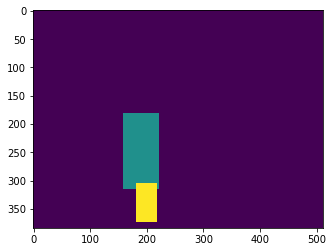

In [13]:
plt.imshow(mskf)

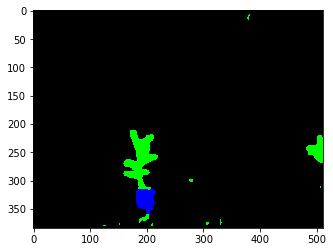

In [14]:
plt.imshow(pred)